In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import gaussian_kde
from flaml import AutoML
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from catboost import CatBoostRegressor
from mpl_toolkits.axes_grid1 import make_axes_locatable

import shap

/data/keeling/a/xx24/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
!hostname

keeling-gpu09


In [3]:
def calculate_metrics_and_plot_single(y_true, y_pred, var):
    # Calculate R2, RMSE, MAE
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # Print the calculated metrics
    print(f'MSE:{mse}')
    print(f'R2: {r2}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

    # Calculate point density
    xy = np.vstack([y_true, y_pred])
    z = gaussian_kde(xy)(xy)

    # Plot y_true vs y_pred density scatter plot
    plt.figure(figsize=(8, 7))

    scatter = plt.scatter(y_true, y_pred, c=z, s=20, cmap='rainbow')

    # Create color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density', fontsize=17)  # Set the color bar label and fontsize
    cbar.ax.tick_params(labelsize=16)  # Set the font size for the color bar ticks

    # Plot a reference line (ideal prediction line y_true = y_pred)
    # plt.plot([1e5, 1e12], [1e5, 1e12], 'r--', lw=2)
    # plt.xlim(1e5, 1e12)
    # plt.ylim(1e5, 1e12)
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel(f'Actual {var}', fontsize=17)
    plt.ylabel(f'Predicted {var}', fontsize=17)
    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, colors='black',
                    grid_color='gray', grid_alpha=0.7, labelsize=16)

    # Annotate with the metrics in the top left corner
    # metrics_text = f'R$^2$: {r2:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}'
    metrics_text = f'R$^2$: {r2:.2f}'
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
             fontsize=14,  # Adjust the font size
             verticalalignment='top', horizontalalignment='left',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.5'))

    # plt.title('Actual vs Predicted Scatter Plot with Density', fontsize=15)
    plt.grid(True)
    plt.show()

In [4]:
def calculate_metrics_and_plot(ax, y_true, y_pred, var):
    # Calculate metrics
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
#     mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Density
    xy = np.vstack([y_true, y_pred])
    z = gaussian_kde(xy)(xy)

    scatter = ax.scatter(y_true, y_pred, c=z, s=20, cmap='rainbow')
    
    # Reference line
    ax.plot([1e5, 1e12], [1e5, 1e12], 'r--', lw=2)
    ax.set_xlim(1e5, 1e12)
    ax.set_ylim(1e5, 1e12)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(f'Actual {var}', fontsize=12)
    ax.set_ylabel(f'Predicted {var}', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # metrics_text = f'R$^2$: {r2:.2f}'
    metrics_text = f'R$^2$: {r2:.4f}\nMAPE: {mape * 100:.2f}%'
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
    
    return scatter

In [2]:
train = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/partmc_train.csv')
test  = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/partmc_test.csv')

In [11]:
input_list = ['Temperature','RH','Bulk_DP','Num_Conc','OA', 'SO4', 'Cl', 'NH4', 'NO3']

In [12]:
train[input_list]

,Temperature,RH,Bulk_DP,Num_Conc,OA,SO4,Cl,NH4,NO3
0,283.512,0.5398,0.152147,181.651772,14.851338,4.574040,32.494052,0.000931,0.262868
1,283.512,0.5398,0.159248,269.546679,22.470256,6.940312,48.927727,0.034501,0.958114
2,283.512,0.5398,0.178122,311.366470,26.348357,8.167535,57.061494,0.155542,2.063369
3,283.512,0.5398,0.195206,364.848062,30.031067,9.335485,64.625470,0.343311,3.463147
4,283.512,0.5398,0.209752,445.723762,36.441919,11.370208,77.991381,0.636066,5.532387
...,...,...,...,...,...,...,...,...,...
47995,243.334,0.5070,0.071363,12187.338800,18.706728,9.410881,48.600241,1.278891,14.021356
47996,243.334,0.5070,0.072727,11182.444275,17.736319,8.928898,45.854703,1.243528,13.679272
47997,243.334,0.5070,0.073677,10335.600164,16.838714,8.466639,43.341999,1.197636,13.297739
47998,243.334,0.5070,0.074649,9605.736092,16.080414,8.076843,41.095899,1.165176,13.147300


[flaml.automl.logger: 05-16 16:22:29] {1728} INFO - task = regression
[flaml.automl.logger: 05-16 16:22:29] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 05-16 16:22:29] {1838} INFO - Minimizing error metric: mape
[flaml.automl.logger: 05-16 16:22:29] {1955} INFO - List of ML learners in AutoML Run: ['xgboost', 'xgb_limitdepth', 'rf', 'lgbm', 'catboost', 'extra_tree', 'histgb']
[flaml.automl.logger: 05-16 16:22:29] {2258} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 05-16 16:22:30] {2393} INFO - Estimated sufficient time budget=1871s. Estimated necessary time budget=10s.
[flaml.automl.logger: 05-16 16:22:30] {2442} INFO -  at 0.2s,	estimator xgboost's best error=382877301599466.8750,	best estimator xgboost's best error=382877301599466.8750
[flaml.automl.logger: 05-16 16:22:30] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-16 16:22:30] {2442} INFO -  at 0.3s,	estimator lgbm's best error=377100109087822.6250,	best estimator lgbm

/tmp/ipykernel_53216/1068111397.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap


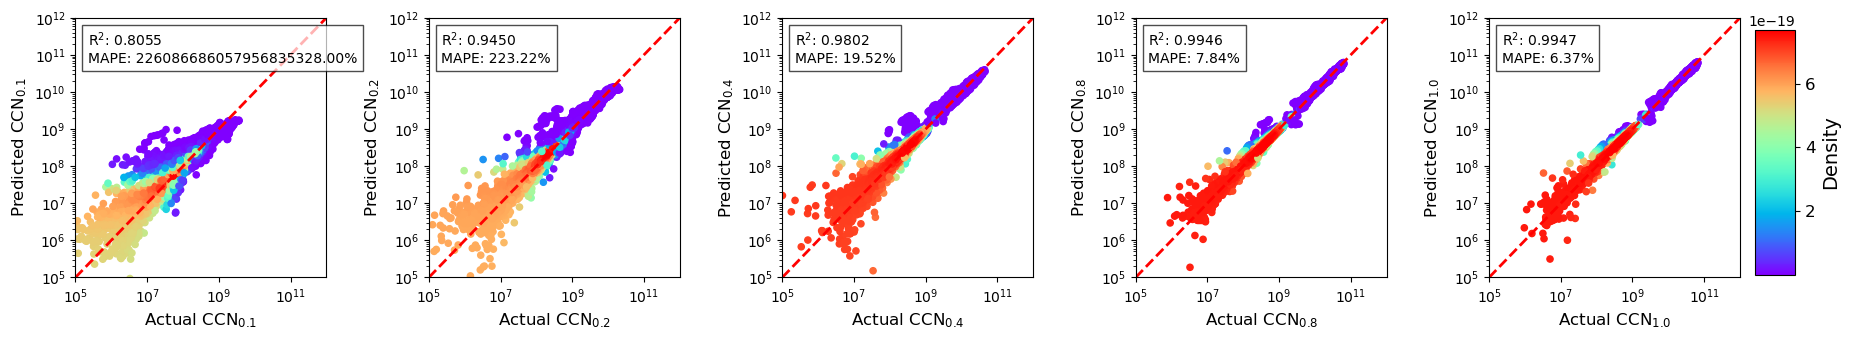

In [20]:
output_list = ['CCN_CS_0.1', 'CCN_CS_0.2','CCN_CS_0.4', 'CCN_CS_0.8', 'CCN_CS_1.0']

fig, axes = plt.subplots(1, 5, figsize=(20, 3.5))
axes = axes.flatten()

for i, output in enumerate(output_list):
    X_train = train[input_list]
    y_train = train[output].squeeze()
    X_test = test[input_list]
    y_test = test[output].squeeze()

    automl = AutoML(random_state=42)
    n_jobs = 16
    time_budget = 1200 # in seconds

    automl_settings = {
        "time_budget": time_budget,  
        "metric": 'mape',  # Metric used to evaluate the models
        "task": 'regression',  
        "eval_method": "cv",  
        "n_splits": 5,  
        "estimator_list": [  
            'xgboost', 
            'xgb_limitdepth', 
            'rf', 
            'lgbm', 
            'catboost', 
            'extra_tree', 
            'histgb', 
        ],
        "n_jobs": n_jobs,  
        "log_file_name": f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/AutoML_emulator_{output}.log',  
    }

    automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
    joblib.dump(automl, f"/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/AutoML_emulator_{output}.pkl")
    
    var = f'CCN$_{{{output[7:]}}}$'
    y_test_pred = automl.predict(X_test)
    scatter = calculate_metrics_and_plot(axes[i], y_test*1e6, y_test_pred*1e6, var)

fig.subplots_adjust(right=0.88)  # Shrink figure a bit to make space for colorbar
cbar_ax = fig.add_axes([0.88, 0.2, 0.02, 0.7])    # [left, bottom, width, height]
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Density', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap
plt.show()

[flaml.automl.logger: 05-16 18:03:08] {1728} INFO - task = regression
[flaml.automl.logger: 05-16 18:03:08] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 05-16 18:03:08] {1838} INFO - Minimizing error metric: mape
[flaml.automl.logger: 05-16 18:03:08] {1955} INFO - List of ML learners in AutoML Run: ['xgboost', 'xgb_limitdepth', 'rf', 'lgbm', 'catboost', 'extra_tree', 'histgb']
[flaml.automl.logger: 05-16 18:03:08] {2258} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 05-16 18:03:08] {2393} INFO - Estimated sufficient time budget=2012s. Estimated necessary time budget=11s.
[flaml.automl.logger: 05-16 18:03:08] {2442} INFO -  at 0.2s,	estimator xgboost's best error=31755061587028.8984,	best estimator xgboost's best error=31755061587028.8984
[flaml.automl.logger: 05-16 18:03:08] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-16 18:03:08] {2442} INFO -  at 0.4s,	estimator lgbm's best error=31781839833717.1484,	best estimator xgboost

[flaml.automl.logger: 05-16 18:03:08] {2442} INFO -  at 0.8s,	estimator histgb's best error=31991828145493.2383,	best estimator lgbm's best error=25209017162349.1641
[flaml.automl.logger: 05-16 18:03:08] {2258} INFO - iteration 5, current learner xgboost
[flaml.automl.logger: 05-16 18:03:08] {2442} INFO -  at 0.9s,	estimator xgboost's best error=31755061587028.8984,	best estimator lgbm's best error=25209017162349.1641
[flaml.automl.logger: 05-16 18:03:08] {2258} INFO - iteration 6, current learner xgboost
[flaml.automl.logger: 05-16 18:03:09] {2442} INFO -  at 1.1s,	estimator xgboost's best error=23115059947687.8477,	best estimator xgboost's best error=23115059947687.8477
[flaml.automl.logger: 05-16 18:03:09] {2258} INFO - iteration 7, current learner xgboost
[flaml.automl.logger: 05-16 18:03:09] {2442} INFO -  at 1.2s,	estimator xgboost's best error=23115059947687.8477,	best estimator xgboost's best error=23115059947687.8477
[flaml.automl.logger: 05-16 18:03:09] {2258} INFO - iteratio

/tmp/ipykernel_53216/3154850813.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap


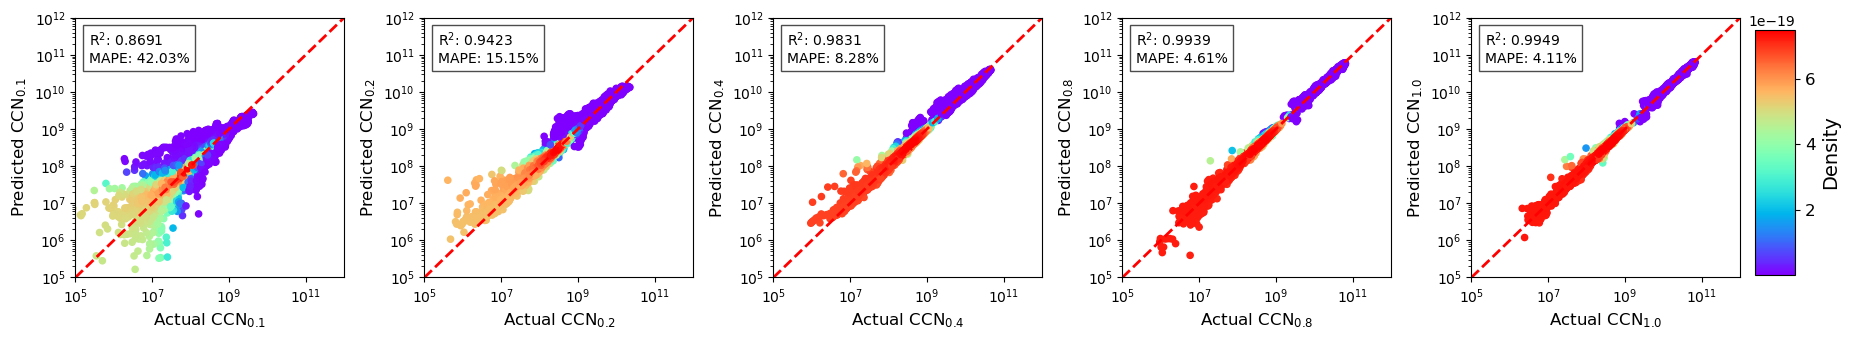

In [21]:
output_list = ['CCN_VS_0.1', 'CCN_VS_0.2', 'CCN_VS_0.4', 'CCN_VS_0.8', 'CCN_VS_1.0']

fig, axes = plt.subplots(1, 5, figsize=(20, 3.5))
axes = axes.flatten()

for i, output in enumerate(output_list):
    X_train = train[input_list]
    y_train = train[output].squeeze()
    X_test = test[input_list]
    y_test = test[output].squeeze()

    automl = AutoML(random_state=42)
    n_jobs = 16
    time_budget = 1200 # in seconds

    automl_settings = {
        "time_budget": time_budget,  
        "metric": 'mape',  # Metric used to evaluate the models
        "task": 'regression',  
        "eval_method": "cv",  
        "n_splits": 5,  
        "estimator_list": [  
            'xgboost', 
            'xgb_limitdepth', 
            'rf', 
            'lgbm', 
            'catboost', 
            'extra_tree', 
            'histgb', 
        ],
        "n_jobs": n_jobs,  
        "log_file_name": f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/AutoML_emulator_{output}.log',  
    }

    automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
    joblib.dump(automl, f"/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/AutoML_emulator_{output}.pkl")
    
    var = f'CCN$_{{{output[7:]}}}$'
        
    y_test_pred = automl.predict(X_test)
    scatter = calculate_metrics_and_plot(axes[i], y_test*1e6, y_test_pred*1e6, var)

fig.subplots_adjust(right=0.88)  # Shrink figure a bit to make space for colorbar
cbar_ax = fig.add_axes([0.88, 0.2, 0.02, 0.7])   # [left, bottom, width, height]
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Density', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap
plt.show()

In [42]:
# ['xgboost', 'xgb_limitdepth', 'rf', 'lgbm', 'lgbm_spark', 'rf_spark', 'lrl1', 'lrl2', 'catboost', 'extra_tree', 'kneighbor', 'transformer', 'transformer_ms', 'histgb', 'svc', 'sgd', 'nb_spark', 'enet', 'lassolars', 'glr_spark', 'lr_spark', 'svc_spark', 'gbt_spark', 'aft_spark']

# load model

In [ ]:
train = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/partmc_train.csv')
test  = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/partmc_test.csv')

input_list = ['Temperature','RH','Bulk_DP','Num_Conc','OA', 'SO4', 'NH4', 'NO3','Cl']
feature_names = ['T', 'RH', r'$\rm D_p$',r'$\rm N_t$','OA',r'$\rm SO_4$','NH4', 'NO3', 'Cl']

In [4]:
PartMC_data.head()

,Global_ID,DayofYear,Time_hr,Temperature,RH,Pressure,Density,Bulk_DP,BC,OC,...,CCN_CS_1.0,CCN_VS_0.1,CCN_VS_0.15,CCN_VS_0.2,CCN_VS_0.25,CCN_VS_0.3,CCN_VS_0.4,CCN_VS_0.6,CCN_VS_0.8,CCN_VS_1.0
0,1,116,1,283.512,0.5398,100000.0,1.228736,0.152147,8.212753e-11,14.849793,...,108.414435,4.393146,23.236317,39.971849,62.671743,90.753696,142.039871,170.976377,178.892829,179.822475
1,1,116,2,283.512,0.5398,100000.0,1.228736,0.159248,1.195284e-10,22.459556,...,265.315681,158.038764,228.278524,243.033744,254.813585,260.599394,265.719094,266.947080,267.330619,267.377005
2,1,116,3,283.512,0.5398,100000.0,1.228736,0.178122,1.346392e-10,26.319633,...,307.794231,221.337726,290.780047,299.068844,303.015667,305.437340,307.936013,308.611500,308.676534,308.685859
3,1,116,4,283.512,0.5398,100000.0,1.228736,0.195206,1.550557e-10,29.973418,...,361.606513,287.096055,348.133693,354.525344,358.642348,360.327751,361.310519,361.533768,361.789294,361.789294
4,1,116,5,283.512,0.5398,100000.0,1.228736,0.209752,1.856348e-10,36.333209,...,441.888676,378.844030,430.151200,434.758560,438.060016,440.008467,441.526181,442.013976,442.069904,442.069904


/tmp/ipykernel_5691/1656526293.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap


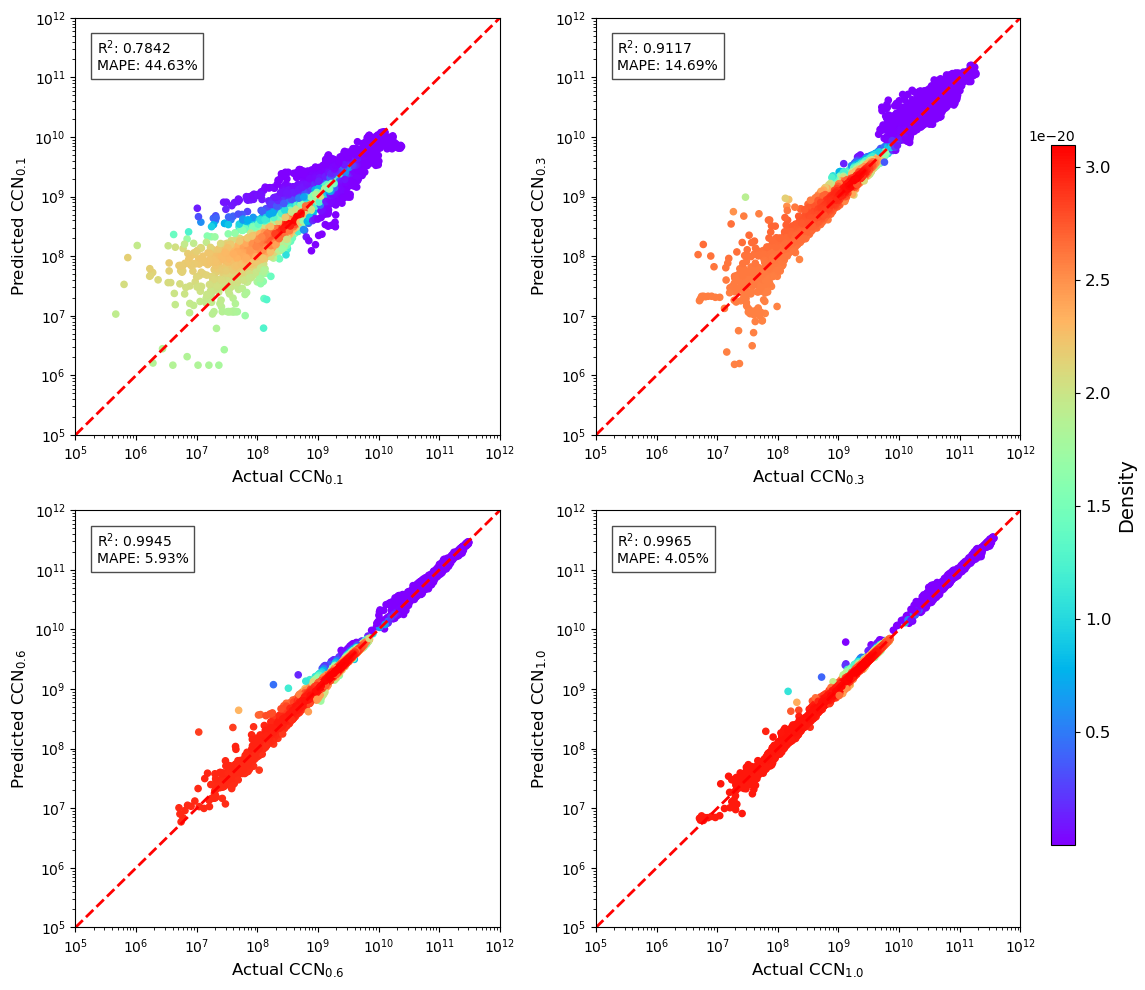

In [ ]:
output_list = ['CCN_VS_0.15', 'CCN_VS_0.4', 'CCN_VS_0.6', 'CCN_VS_1.0']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, output in enumerate(output_list):
    with open(f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/AutoML_emulator_{output_list[i]}.pkl', 'rb') as f:    
        automl = joblib.load(f)
    X_train = train[input_list]
    y_train = train[output].squeeze()
    X_test = test[input_list]
    y_test = test[output].squeeze()
    
    var = f'CCN$_{{{output[-3:]}}}$'
        
    y_test_pred = automl.predict(X_test)
    scatter = calculate_metrics_and_plot(axes[i], y_test*1e6, y_test_pred*1e6, var)

fig.subplots_adjust(right=0.88)  
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Density', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

In [29]:
automl = joblib.load(f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/AutoML_emulator_CCN_VS_1.0.pkl')
estimator = automl.model.estimator

X_test = test[input_list]

if isinstance(estimator, CatBoostRegressor):
    explainer = shap.TreeExplainer(estimator, feature_perturbation='tree_path_dependent')

    X_test_sample = X_test.sample(n=1000, random_state=42)
    shap_values_sample = explainer(X_test_sample, check_additivity=False)
    
else: #isinstance(estimator, ExtraTreesRegressor):
    explainer = shap.TreeExplainer(estimator)

    X_test_sample = X_test.sample(n=1000, random_state=42)
    shap_values_sample = explainer(X_test_sample, check_additivity=False)
    
# else:
#     print("estimator 既不是 CatBoostRegressor，也不是 ExtraTreesRegressor")

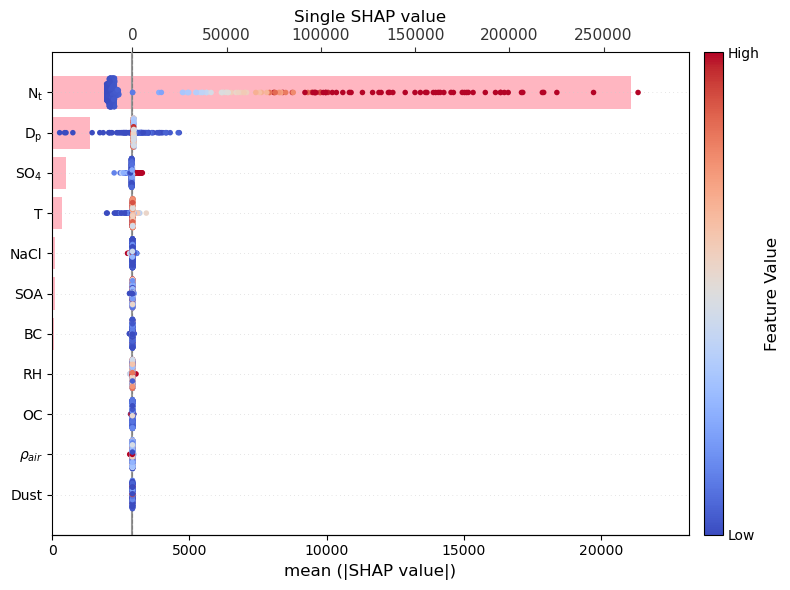

In [30]:
# 1) 计算 & 排序（降序）
shap_arr      = shap_values_sample.values
mean_abs_shap = np.abs(shap_arr).mean(axis=0)
order         = np.argsort(mean_abs_shap)[::-1]   # highest first
labels        = [feature_names[i] for i in order]

# 2) 准备倒序的 y 位置
N = len(order)
y_positions = np.arange(N)[::-1]

# 3) 重排 Explanation 对象
shap_bees = shap_values_sample[:, order]

# 4) 创建图和双 X 轴
fig, ax_bar    = plt.subplots(figsize=(8,6))
ax_scatter     = ax_bar.twiny()

# 5) 在倒序 y_positions 上画水平柱状图
ax_bar.barh(
    y_positions,
    mean_abs_shap[order],
    color='lightpink',
    edgecolor='none'
)

# 6) 在相同 y_positions 上画 beeswarm
#    beeswarm 本身会 jitter y，所以我们先画空点仅占位置：
for yi in y_positions:
    ax_scatter.plot([], [])  # 占位，不影响

shap.plots.beeswarm(
    shap_bees,
    ax=ax_scatter,
    show=False,
    plot_size=None,
    color_bar=False,
    color=plt.get_cmap("coolwarm"),
    max_display=None
)

# 7) 画上方 x=0 竖线
ax_scatter.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# 8) 设置坐标轴范围和位置
ax_bar.set_xlim(0, mean_abs_shap.max()*1.1)
ax_scatter.set_xlim(shap_arr.min()*1.1, shap_arr.max()*1.1)

ax_bar.xaxis.set_ticks_position('bottom')
ax_bar.xaxis.set_label_position('bottom')
ax_scatter.xaxis.set_ticks_position('top')
ax_scatter.xaxis.set_label_position('top')

# 9) 只在 ax_bar 上设置 y 轴标签
ax_bar.set_yticks(y_positions)
ax_bar.set_yticklabels(labels, fontsize=10)

# 显式打开 ax_bar 的左侧 ticks 和 ticklabels
ax_bar.tick_params(axis='y', which='both', left=True, labelleft=True)

# 关闭 ax_scatter 的 y 轴
ax_scatter.yaxis.set_visible(False)

# # 10) 清掉 ax_scatter 的 y 轴刻度
# ax_scatter.set_yticks([])
# ax_scatter.set_yticklabels([])

ax_bar.set_xlabel("mean (|SHAP value|)", fontsize=12)
ax_scatter.set_xlabel("Single SHAP value", fontsize=12)

# 11) 外置 Low–High colorbar
sc = ax_scatter.collections[-1]
divider = make_axes_locatable(ax_scatter)
cax     = divider.append_axes("right", size="3%", pad=0.15)
cbar    = fig.colorbar(sc, cax=cax, orientation='vertical')
vmin, vmax = sc.norm.vmin, sc.norm.vmax
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(['Low','High'])
cbar.set_label("Feature Value", fontsize=12)
cbar.ax.tick_params(size=0)

plt.tight_layout()
plt.show()